In [50]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd
import skforecast

print(skforecast.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/joaquin/Documents/GitHub/skforecast
0.19.1


In [51]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import skforecast
from skforecast.stats import Sarimax, Arar, Ets
from skforecast.recursive import ForecasterStats, ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, backtesting_stats, backtesting_forecaster
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

from skforecast.plot import set_dark_theme
from skforecast.datasets import fetch_dataset
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import aeon
from aeon.forecasting.stats import ARIMA, ETS
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
import matplotlib.pyplot as plt
import timeit

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
print(f"skforecast version: {skforecast.__version__}")
print(f"aeon version      : {aeon.__version__}")

skforecast version: 0.19.1
aeon version      : 1.3.0


# Fuel consumption dataset

In [52]:
# Download data
# ==============================================================================
data = fetch_dataset(name='fuel_consumption', raw=True)
data = data[['Fecha', 'Gasolinas']]
data = data.rename(columns={'Fecha': 'date', 'Gasolinas': 'y'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.loc[:'1990-01-01 00:00:00', ['y']]
data['month'] = data.index.month
data = pd.get_dummies(data, columns=['month'], prefix='month', drop_first=False, dtype=float)
data

╭──────────────────────────────── fuel_consumption ────────────────────────────────╮
│ Description:                                                                     │
│ Monthly fuel consumption in Spain from 1969-01-01 to 2022-08-01.                 │
│                                                                                  │
│ Source:                                                                          │
│ Obtained from Corporación de Reservas Estratégicas de Productos Petrolíferos and │
│ Corporación de Derecho Público tutelada por el Ministerio para la Transición     │
│ Ecológica y el Reto Demográfico. https://www.cores.es/es/estadisticas            │
│                                                                                  │
│ URL:                                                                             │
│ https://raw.githubusercontent.com/skforecast/skforecast-                         │
│ datasets/main/data/consumos-combustibles-mensual.csv                             │
│                                                                                  │
│ Shape: 644 rows x 6 columns                                                      │
╰──────────────────────────────────────────────────────────────────────────────────╯

,y,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
1969-01-01,166875.2129,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-02-01,155466.8105,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-03-01,184983.6699,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-04-01,202319.8164,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-05-01,206259.1523,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989-09-01,687649.2852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1989-10-01,669889.1602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1989-11-01,601413.8867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


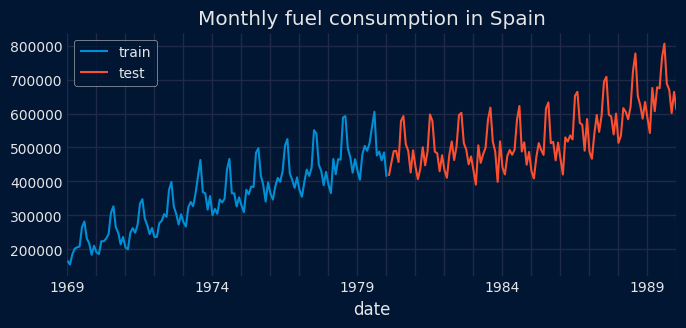

In [53]:
# Train-test dates
# ======================================================================================
set_dark_theme()
end_train = '1980-01-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

In [54]:
# start = timeit.default_timer()
# forecaster = ForecasterStats(
#                 estimator = Ets()
#             )
# forecaster.fit(y=data_train['y'])
# end = timeit.default_timer()
# time_fit_ets_skforecast = end - start
# print(f"Training time ETS skforecast  : {time_fit_ets_skforecast} seconds")

# Compare ets from skforecast, aeon and statsmodels

## Performance Note

⚠️ **Important**: The first call to ETS includes JIT compilation (~0.4s overhead). Subsequent calls are much faster (~0.005s). This is a one-time cost per Python session.

To get accurate performance measurements, run each cell **twice** and use the second timing.

In [55]:
# Warmup: Pre-compile JIT functions (run this once after importing)
# ==============================================================================
# print("Warming up JIT cache...")
# import warnings
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     dummy_forecaster = ForecasterStats(estimator=Ets(model="ANN"))
#     dummy_forecaster.fit(y=data_train['y'].iloc[:20])
#     _ = dummy_forecaster.predict(steps=1)
# print("✅ JIT cache ready. Subsequent ETS calls will be fast (~0.005s per fit)")

In [56]:
start = timeit.default_timer()

forecaster = ForecasterStats(
                estimator = Ets(
                    model="AMM",        # Additive error ("A"), no trend ("N"), no seasonal ("N")
                    damped=False,       # No damped trend
                    m=12,                # Seasonal period (irrelevant since no seasonal, but default is 1)
                    lambda_param=None,  # No Box-Cox transformation
                    lambda_auto=False,  # No automatic Box-Cox
                    bounds="both"       # Default bounds (similar to statsmodels' None, which uses internal defaults)
                )
            )
forecaster.fit(y=data_train['y'])
end = timeit.default_timer()
time_fit_ets_skforecast = end - start
print(f"Training time ETS skforecast  : {time_fit_ets_skforecast} seconds")
start = timeit.default_timer()
predictions_skforecast = forecaster.predict(steps=24)
end = timeit.default_timer()
time_pred_ets_skforecast = end - start
prediction_intervals_skforecast = forecaster.predict_interval(steps=24, alpha=0.05)
print(f"Prediction time ETS skforecast: {time_pred_ets_skforecast} seconds")

Training time ETS skforecast  : 0.005174068000997067 seconds
Prediction time ETS skforecast: 0.001464602999476483 seconds


In [57]:
forecaster = ForecasterStats(
                 estimator=ETS(error_type='additive', trend_type='additive', seasonality_type='multiplicative', seasonal_period=12)
             )
start = timeit.default_timer()
forecaster.fit(y=data_train['y'])
end = timeit.default_timer()
time_fit_ets_aeon = end - start
print(f"Training time ETS aeon  : {time_fit_ets_aeon} seconds")
start = timeit.default_timer()
predictions_aeon = forecaster.predict(steps=24)
end = timeit.default_timer()
time_pred_ets_aeon = end - start
# prediction_intervals_aeon = forecaster.predict_interval(steps=24, alpha=0.05)
print(f"Prediction time ETS aeon: {time_pred_ets_aeon} seconds")

Training time ETS aeon  : 0.003977764999945066 seconds
Prediction time ETS aeon: 0.003923036998457974 seconds


In [ ]:
# Nixtla StatsForecast ETS
# ==============================================================================
df_nixtla = data_train['y'].reset_index()
df_nixtla.columns = ['ds', 'y']
df_nixtla['unique_id'] = 'fuel'

start = timeit.default_timer()
sf = StatsForecast(
    models=[AutoETS(season_length=12, model='ZZZ')],
    freq='MS'
)
sf.fit(df=df_nixtla)
end = timeit.default_timer()
time_fit_ets_nixtla = end - start
print(f"Training time ETS nixtla  : {time_fit_ets_nixtla} seconds")

start = timeit.default_timer()
predictions_nixtla_df = sf.predict(h=24, level=[95])
end = timeit.default_timer()
time_pred_ets_nixtla = end - start

# Extract predictions and prediction intervals
predictions_nixtla = predictions_nixtla_df['AutoETS'].values
predictions_nixtla = pd.Series(predictions_nixtla, index=pd.date_range(start=data_test.index[0], periods=24, freq='MS'))

prediction_intervals_nixtla = pd.DataFrame({
    'lower_bound': predictions_nixtla_df['AutoETS-lo-95'].values,
    'upper_bound': predictions_nixtla_df['AutoETS-hi-95'].values
}, index=predictions_nixtla.index)

print(f"Prediction time ETS nixtla: {time_pred_ets_nixtla} seconds")

Training time ETS nixtla  : 0.2542374659988127 seconds
Prediction time ETS nixtla: 0.010036801999376621 seconds


In [59]:
model = ExponentialSmoothing(
    data_train['y'],
    trend='add',
    seasonal='mul',
    seasonal_periods=12
)
start = timeit.default_timer()
model = model.fit()
end = timeit.default_timer()
time_fit_ets_statsmodels = end - start
print(f"Training time ETS statsmodels  : {time_fit_ets_statsmodels} seconds")
start = timeit.default_timer()
predictions_statsmodels = model.forecast(steps=24)
end = timeit.default_timer()
time_pred_ets_statsmodels = end - start
resid = model.resid
sigma = resid.std(ddof=1)
z = 1.96
h_index = np.arange(1, 24 + 1)
lower_approx = predictions_statsmodels - z * sigma * np.sqrt(h_index)
upper_approx = predictions_statsmodels + z * sigma * np.sqrt(h_index)
prediction_intervals_statsmodels = pd.DataFrame({
    'lower_bound': lower_approx,
    'upper_bound': upper_approx
})

print(f"Prediction time ETS statsmodels: {time_pred_ets_statsmodels} seconds")

Training time ETS statsmodels  : 0.19378038800095965 seconds
Prediction time ETS statsmodels: 0.012371451000944944 seconds


In [60]:
# Table of times
# ==============================================================================
times_ets = pd.DataFrame({
    'fit_time_seconds': [time_fit_ets_skforecast, time_fit_ets_aeon, time_fit_ets_nixtla, time_fit_ets_statsmodels],
    'predict_time_seconds': [time_pred_ets_skforecast, time_pred_ets_aeon, time_pred_ets_nixtla, time_pred_ets_statsmodels]
}, index=['ETS skforecast', 'ETS aeon', 'ETS nixtla', 'ETS statsmodels'])
times_ets.sort_values(by='fit_time_seconds')

,fit_time_seconds,predict_time_seconds
ETS aeon,0.003978,0.003923
ETS skforecast,0.005174,0.001465
ETS statsmodels,0.193780,0.012371
ETS nixtla,0.254237,0.010037


,skforecast,aeon,nixtla,statsmodels
1980-02-01,419019.957822,415913.953887,417007.684368,415845.763257
1980-03-01,487582.742761,484605.626584,485262.739025,483093.518480
1980-04-01,504077.943837,487726.359076,501829.054205,497800.142558
1980-05-01,505294.042465,483728.370592,504057.712850,499527.252473
1980-06-01,524043.119332,495274.057561,522587.466943,519031.538186
1980-07-01,638621.305438,582314.444362,635413.616464,626287.531650
1980-08-01,668104.724836,604727.928882,666200.300434,653098.919874
1980-09-01,543251.473217,493895.652010,540238.801224,532150.599667
1980-10-01,519066.309461,486423.494714,515192.383729,513349.105935
1980-11-01,463176.798524,447959.513269,460172.423400,464009.628076


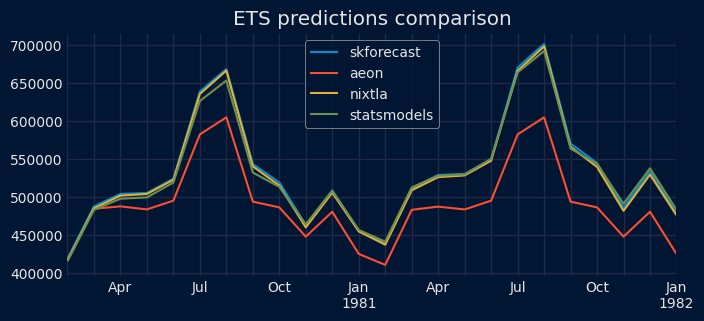

In [61]:
# compare predictions
# ======================================================================================
predictions = pd.DataFrame({
    'skforecast': predictions_skforecast,
    'aeon'      : predictions_aeon,
    'nixtla'    : predictions_nixtla,
    'statsmodels': predictions_statsmodels
})
display( predictions )
predictions.plot(figsize=(7, 3), title='ETS predictions comparison');

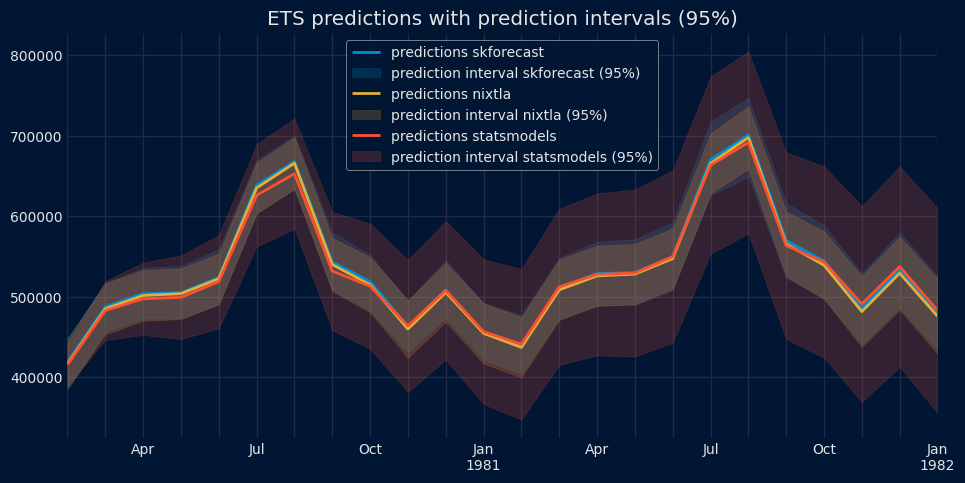

In [62]:
# Plot predictions with prediction intervals
# ======================================================================================
fig, ax = plt.subplots(figsize=(10, 5))

# Skforecast
predictions_skforecast.plot(ax=ax, label='predictions skforecast', color='C0', linewidth=2)
ax.fill_between(
    prediction_intervals_skforecast.index,
    prediction_intervals_skforecast['lower_bound'],
    prediction_intervals_skforecast['upper_bound'],
    color='C0',
    alpha=0.2,
    label='prediction interval skforecast (95%)'
)

# Nixtla
predictions_nixtla.plot(ax=ax, label='predictions nixtla', color='C2', linewidth=2)
ax.fill_between(
    prediction_intervals_nixtla.index,
    prediction_intervals_nixtla['lower_bound'],
    prediction_intervals_nixtla['upper_bound'],
    color='C2',
    alpha=0.2,
    label='prediction interval nixtla (95%)'
)

# Statsmodels
predictions_statsmodels.plot(ax=ax, label='predictions statsmodels', color='C1', linewidth=2)
ax.fill_between(
    prediction_intervals_statsmodels.index,
    prediction_intervals_statsmodels['lower_bound'],
    prediction_intervals_statsmodels['upper_bound'],
    color='C1',
    alpha=0.2,
    label='prediction interval statsmodels (95%)'
)

ax.set_title('ETS predictions with prediction intervals (95%)')
ax.legend();

In [66]:
# Compare prediction interval widths
# ======================================================================================
interval_widths = pd.DataFrame({
    'skforecast': prediction_intervals_skforecast['upper_bound'] - prediction_intervals_skforecast['lower_bound'],
    'nixtla': prediction_intervals_nixtla['upper_bound'] - prediction_intervals_nixtla['lower_bound'],
    'statsmodels': prediction_intervals_statsmodels['upper_bound'] - prediction_intervals_statsmodels['lower_bound']
})

print("\nPrediction Interval Widths Summary (95% confidence):")
print("=" * 60)
print(interval_widths.describe().T[['mean', 'std', 'min', 'max']])
print("\nAverage interval width:")
print(interval_widths.mean().sort_values())


Prediction Interval Widths Summary (95% confidence):
                      mean           std           min            max
skforecast    76780.250344  12025.749953  61113.197281   98587.474152
nixtla        73417.226968   9137.753000  63101.584904   93533.313321
statsmodels  174486.428752  58408.254787  51934.490430  254426.003211

Average interval width:
nixtla          73417.226968
skforecast      76780.250344
statsmodels    174486.428752
dtype: float64


In [ ]:
# Backtesting ForecasterStats with ETS skforecast
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True,
        fixed_train_size   = False,
)
forecaster = ForecasterStats(
                 estimator=Ets(
                    model="AMM",        # Additive error ("A"), no trend ("N"), no seasonal ("N")
                    damped=False,       # No damped trend
                    m=12,                # Seasonal period (irrelevant since no seasonal, but default is 1)
                    lambda_param=None,  # No Box-Cox transformation
                    lambda_auto=False,  # No automatic Box-Cox
                    bounds="both"       # Default bounds (similar to statsmodels' None, which uses internal defaults)
                )
             )

start = timeit.default_timer()
metric_ets_skforecast, pred_ets_skforecast = backtesting_stats(
    forecaster = forecaster,
    y          = data['y'],
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_ets_skforecast = stop - start

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Backtesting ForecasterStats with ETS aeon
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True,
        fixed_train_size   = False,
)
forecaster = ForecasterStats(
                 estimator=ETS(error_type='additive', trend_type='additive', seasonality_type='multiplicative', seasonal_period=12),
             )

start = timeit.default_timer()
metric_ets_aeon, pred_ets_aeon = backtesting_stats(
    forecaster = forecaster,
    y          = data['y'],
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_ets_aeon = stop - start

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Backtesting ForecasterStats with ETS nixtla
# ==============================================================================
# Note: Nixtla's StatsForecast doesn't integrate directly with skforecast's backtesting
# For a fair comparison, we would need to implement custom backtesting for nixtla
print("Note: Nixtla StatsForecast backtesting would require custom implementation")

Note: Nixtla StatsForecast backtesting would require custom implementation


In [ ]:
# Results
# ==============================================================================
results = pd.DataFrame(
    {
        "Model": [
            "Ets skforecast",
            "ETS aeon",
        ],
        "MAE": [
            
            metric_ets_skforecast.at[0, "mean_absolute_error"],
            metric_ets_aeon.at[0, "mean_absolute_error"],
        ],
        "Elapsed Time (s)": [
            elapsed_time_ets_skforecast,
            elapsed_time_ets_aeon,
        ],
    }
)
results = results.sort_values(by="MAE").reset_index(drop=True)
results

,Model,MAE,Elapsed Time (s)
0,ETS aeon,19848.024097,0.129672
1,Ets skforecast,19955.289366,0.080795


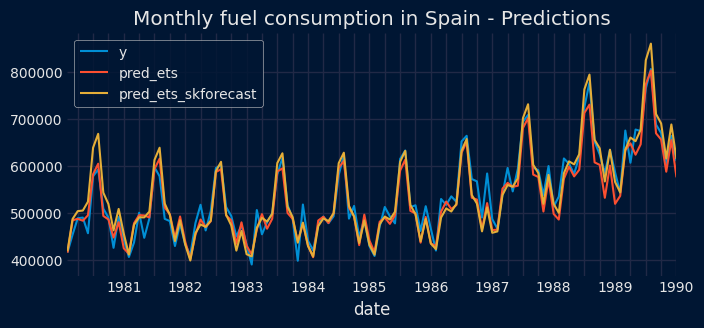

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data['y'].loc[data_test.index].plot(ax=ax, label='y')
pred_ets_aeon['pred'].plot(ax=ax, label='pred_ets')
pred_ets_skforecast['pred'].plot(ax=ax, label='pred_ets_skforecast')
ax.set_title('Monthly fuel consumption in Spain - Predictions')
ax.legend();